In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gsw
import pdb
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import Image
import matplotlib.colors as colors
from scipy.interpolate import griddata
import geopandas as gpd
from shapely.geometry import Point

<IPython.core.display.Javascript object>


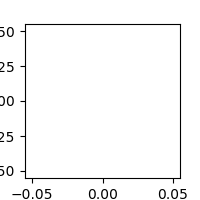

In [2]:
%matplotlib notebook
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

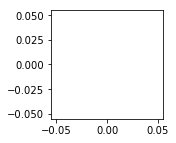

In [3]:
%matplotlib inline
plt.figure(figsize=(2,2))
plt.plot()
plt.show()

In [4]:
dfmg = pd.read_csv("dfmg_glDist.csv")
del dfmg['Unnamed: 0']
del dfmg['Unnamed: 0.1']
dfmg.loc[:,'JULD'] = pd.to_datetime(dfmg.loc[:, 'JULD'])

In [5]:
import plot_stations as pltStn
import importlib
importlib.reload(pltStn)

import plot_bathy as pltBathy
import importlib
importlib.reload(pltBathy)

import find_depth_averages_v2 as averageProfile
import plot_var_contours_with_distance as plt2dDepthVsDist

import plot_station_bot_sal as pbs

import plot_topView_contourf as topView
importlib.reload(topView)

import plot_monthly_count as monthCount
importlib.reload(monthCount)

import plot_theta_sal
importlib.reload(plot_theta_sal)

import plot_year_vs_salAverages as pltSalYearAvg
importlib.reload(pltSalYearAvg)

<module 'plot_year_vs_salAverages' from '/media/data/Datasets/MEOP/MEOP-CTD_2016-07-12/UK/myScripts/plot_year_vs_salAverages.py'>

In [23]:
WSO_source = (dfmg['CTEMP'] <= -1.7 ) & (dfmg["PSAL_ADJUSTED"] > 34.5)
WSO_prod = (dfmg['CTEMP'] <= -0.8) & (dfmg['CTEMP'] >= -1.2) & (dfmg["PSAL_ADJUSTED"] > 34.5)

box1 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box2 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)
box3 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -60) & (dfmg["LONGITUDE"] < -40)
box4 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -40) & (dfmg["LONGITUDE"] < -20)

box5 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box6 = (dfmg["LATITUDE"] > -80) & (dfmg["LATITUDE"] < -75) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)
box7 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > 160) & (dfmg["LONGITUDE"] < 180)
box8 = (dfmg["LATITUDE"] > -75) & (dfmg["LATITUDE"] < -70) & (dfmg["LONGITUDE"] > -180) & (dfmg["LONGITUDE"] < -160)

box9 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 60) & (dfmg["LONGITUDE"] < 70)
box10 = (dfmg["LATITUDE"] > -70) & (dfmg["LATITUDE"] < -65) & (dfmg["LONGITUDE"] > 70) & (dfmg["LONGITUDE"] < 80)

Weddell = (box1 | box2 | box3| box4)
Ross = (box5 | box6 | box7 | box8)
Prydz = (box9 | box10)
EBS = (dfmg['LONGITUDE'] > -80) & (dfmg['LONGITUDE'] < -60) #Eastern Bellingshausen Sea
WBS = (dfmg['LONGITUDE'] > -100) & (dfmg['LONGITUDE'] < -80) # Western Bellingshausen Sea

dfmg['mab'] = abs(dfmg['ECHODEPTH'] - dfmg['DEPTH'])
lt60 = abs(dfmg['mab']) < 60
lt100 = abs(dfmg['mab']) < 100
lt200 = abs(dfmg['mab']) < 200

lowSurfSal = (dfmg['PSAL_ADJUSTED'] < 33.5) & (dfmg['DEPTH'] > -100)
cdw = (dfmg['PSAL_ADJUSTED'] > 34.6) & (dfmg['CTEMP'] > 0)
maxTemp = (dfmg.groupby('PROFILE_NUMBER')['CTEMP'].transform(max) == dfmg['CTEMP'])
gline_le_50km = dfmg['DIST_GLINE'] <= 50
gline_le_100km = dfmg['DIST_GLINE'] <= 100
gline_le_150km = dfmg['DIST_GLINE'] <= 150
gline_le_25km = dfmg['DIST_GLINE'] <= 25
gline_le_75km = dfmg['DIST_GLINE'] <= 75

mask_theta_sal_not_nan = ~(dfmg.loc[:, 'CTEMP'].isnull() + dfmg.loc[:, 'PSAL_ADJUSTED'].isnull())

/home/km/anaconda2/envs/py35new/lib/python3.5/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  unsupported[op_str]))


In [7]:
year_mask = []
years = np.sort(dfmg['JULD'].dt.year.unique())
for i in range(len(years)):
    mask = dfmg['JULD'].dt.year == years[i]
    year_mask.append(mask)
month_mask = []
for i in range(12):
    mask = dfmg['JULD'].dt.month == i+1
    month_mask.append(mask)
    
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [8]:
def sel_months(df, months=[1]):
    return df['JULD'].dt.month.isin(months)

def get_mask_from_prof_mask(df, profmask):
    profs = dfmg.loc[profmask, 'PROFILE_NUMBER'].unique()
    mask = dfmg.loc[:, 'PROFILE_NUMBER'].isin(profs)
    
    return mask

def play_beep():
    import os
    duration = 1  # second
    freq = 440  # Hz
    os.system('play --no-show-progress --null --channels 1 synth %s sine %f' % (duration, freq))

## Following 2 cells are 1 time only, hence turned into markdown

dfmg['deep_flag'] = np.zeros(len(dfmg))
def apply_deep_flag(df):
    mab = df.loc[:, 'mab'].values
    flag = 0
    if( abs(mab[-1]) < 60):
        flag = 1
    if(abs(df.ECHODEPTH.values[-1]) < 50 ):
        flag = 1
    df.loc[:, 'deep_flag'] = flag
    return df
dfmg = dfmg.groupby('PROFILE_NUMBER').apply(apply_deep_flag)

dfmg.to_csv("dfmg_glDist.csv")